In [ ]:
import pandas as pd
import seaborn as sns
import os
from openai import OpenAI
import configurations as c


In [6]:
df = pd.read_csv("data/DisneylandReviews.csv", encoding='latin1')
df['Branch'] = df['Branch'].astype('category')
df["Year_Month"] = pd.to_datetime(df["Year_Month"], format="%Y-%m", errors = "coerce")
df["Reviewer_Location"] = df["Reviewer_Location"].astype('category')
df = df.rename(columns={
    "Reviewer_Location" : "Location"
})

In [6]:
#make a new dataset randomly sampling 1000 entries
df_sample = df.sample(n=1000, random_state=1)
df_sample

,Review_ID,Rating,Year_Month,Location,Review_Text,Branch
12008,531138321,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California
42394,25004598,1,NaT,United States,We arrived on 15th February 2009 and were due ...,Disneyland_Paris
24748,155279085,5,2012-12-01,United States,Nothing really new in the Magic Kingdom from t...,Disneyland_California
42609,3460644,1,NaT,United States,My husband and I recently returned from a long...,Disneyland_Paris
10719,594693531,5,2018-07-01,United States,"You will definitely want to plan out your day,...",Disneyland_California
...,...,...,...,...,...,...
18743,283963913,5,2015-06-01,United States,The park was awesome and all of the 60th decor...,Disneyland_California
34250,362480264,4,2016-04-01,United Kingdom,What more can I say my 2 kids 4 and 6 had an a...,Disneyland_Paris
34894,330029779,5,2015-11-01,New Zealand,Cannot fault the visit. The magic totally aliv...,Disneyland_Paris
38297,204781099,4,2014-05-01,United Kingdom,We Went to disneyland from Friday 2nd Monday 5...,Disneyland_Paris


In [ ]:
from pydantic import BaseModel
from typing import List, Optional

class CodedElement(BaseModel):
    touchpoint: str
    sentiment: str # "positive", "negative" or "neutral"
    code: str
    text_excerpt: str

class DemographicInfo(BaseModel):
    travel_party: Optional[str] = None
    first_visit: Optional[str] = None # "Yes", "No", or "Unknown"
    visit_timing: Optional[str] = None # Season, holiday, time of day, day of week

class ReviewAnalysis(BaseModel):
    review_id: str
    coded_elements: List[CodedElement]
    demographic_info: DemographicInfo

In [235]:
def prompt():
    """
    You are tasked with analyzing Disneyland reviews to identify the primary drivers of guest satisfaction across the complete guest journey.

    For each review, identify specific mentions that affected the guest experience at different touchpoints, marking them as either positive or negative.

    GUEST JOURNEY TOUCHPOINTS:
    Use ONLY the following touchpoint categories (do not create your own) - all in lowercase:
    - pre-visit (use for planning, booking, website experience, app usage before arrival)
    - entry/admission (use for parking, tickets, entry gates, security screening, arrival experience)
    - attractions (use for rides, interactive exhibits, wait times, ride operations)
    - entertainment (use for parades, shows, fireworks, street performers)
    - characters (use for character meet-and-greets, character interactions, photo opportunities)
    - staff (use for all employee interactions including ride operators, food service staff, retail staff)
    - food/beverage (use for restaurants, snack stands, food quality, dining experience)
    - retail (use for shopping experiences, merchandise, souvenirs)
    - facilities (use for restrooms, baby care, first aid, accessibility features)
    - cleanliness (use for park maintenance, trash management, overall park cleanliness)
    - navigation (use for park layout, wayfinding, walking experience, crowding)
    - value (use for price-related comments, perceived worth, packages, discounts)
    - atmosphere (use for theming, ambiance, music, decorations, overall feel)
    - timing (use ONLY when time of visit directly impacts satisfaction, such as "weekday visits are better" or "morning hours have shorter lines")
    - post-visit (use for follow-up, memories, overall reflections after leaving)
    - comparison (use when comparing to other Disney parks or similar attractions)

    DEMOGRAPHIC INFO:
    For demographic information, capture the following when mentioned (even if just mentioned factually without impact on satisfaction):
    - Travel party composition (family, couple, solo, friends)
    - First visit status (yes/no)
    - Visit timing (season, holiday, time of day, day of week)

    QUEUE-RELATED CODING GUIDELINES:
    For any mention of queues, waiting times, lines, or crowding across ANY touchpoint:
    1. Always include one of these terms in your code: "queue", "wait time", "line", or "crowding"
    2. Be specific about which service the queue is for (e.g., "short ride queues" rather than just "short queues")
    3. Place the queue code under the most relevant touchpoint:
       - attractions: for ride queues, virtual queues, FastPass systems
       - entry/admission: for entry gates, ticket booths, security screening
       - food/beverage: for restaurant waiting, ordering lines, pickup queues
       - entertainment: for show seating, parade viewing spots
       - characters: for character meet-and-greet lines
       - facilities: for restroom queues
       - navigation: for general crowding or movement flow issues

    CODES:
    Your codes must identify the specific driver of satisfaction or dissatisfaction, capturing the exact aspect that influenced the experience.
    Examples of good codes:
    - "efficient online ticket purchase" (pre-visit)
    - "short security line wait" (entry/admission)
    - "minimal ride queue times" (attractions)
    - "convenient virtual queue system" (attractions)
    - "manageable character line wait" (characters)
    - "knowledgeable staff recommendations" (staff)
    - "quick food service lines" (food/beverage)
    - "reasonable restroom wait times" (facilities)
    - "excessive parade viewing crowding" (entertainment)
    - "low general crowd density" (navigation)
    - "advantageous weekday crowds" (timing)

    IMPORTANT DISTINCTION:
    - Only code "timing" as a touchpoint when it DIRECTLY impacts satisfaction (e.g., "Going on weekdays was great because there were no lines!")
    - When timing is just mentioned factually without directly affecting satisfaction (e.g., "We visited in December"), capture it in demographic_info.visit_timing

    For each coded element, provide:
    - The specific touchpoint category (from the list above, in lowercase)
    - Sentiment as "positive" or "negative" (not "+" or "-")
    - A specific descriptive code (3-5 words that precisely identify the satisfaction driver)
    - The exact text excerpt from the review that supports this code (do not alter the quote)

    Structure your output according to the provided schema.
    Here is the review:
    """
    return prompt.__doc__

In [236]:
#if u want to use gemini
from google import genai

secret = c.GEMINI_API_KEY
client = genai.Client(api_key = secret)
def chatgpt(input):
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=input,
        config={
            'response_mime_type': 'application/json',
            'response_schema': ReviewAnalysis,
            'system_instruction': prompt() 
        },
    )
    return response.text

In [ ]:
#if you want to use chatgpt
secret = c.OPENAI_API_KEY
client = OpenAI(api_key = secret)
def chatgpt(input_text: str) -> ReviewAnalysis:
    system_prompt = prompt()
    user_prompt = input_text 
    response = client.beta.chat.completions.parse(
        model="gpt-4o-mini-2024-07-18",
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        response_format = ReviewAnalysis
    )
    return response.choices[0].message

In [ ]:
# function to analyze the dataframe of reviews
llm_output = []
for i in range(0, 1000):
    review = input = f"ID: {df_sample.iloc[i]['Review_ID']}, Review Text:{df_sample.iloc[i]["Review_Text"]}, Where the reviewer is from: {df_sample.iloc[i]['Location']}, Disney Branch: {df_sample.iloc[i]['Branch']}"
    response = chatgpt(review)
    print(response)
    print(f"{i}TH REVIEW")
    llm_output.append(response)

{
  "review_id": "74875940",
  "coded_elements": [
    {
      "touchpoint": "value",
      "sentiment": "negative",
      "code": "expensive overall experience",
      "text_excerpt": "It was so expensive"
    },
    {
      "touchpoint": "attractions",
      "sentiment": "negative",
      "code": "excessive ride queue times",
      "text_excerpt": "the lines are too long."
    },
    {
      "touchpoint": "attractions",
      "sentiment": "negative",
      "code": "long ride wait time",
      "text_excerpt": "The wiat time for a ride that was like 1 minute long, was at least 70 minutes"
    },
    {
      "touchpoint": "value",
      "sentiment": "negative",
      "code": "questionable cost worth",
      "text_excerpt": "Was it worth the cost? I doubt it."
    },
    {
      "touchpoint": "staff",
      "sentiment": "positive",
      "code": "staff trying their best",
      "text_excerpt": "The staff try their best I guess."
    },
    {
      "touchpoint": "value",
      "sentiment"

In [ ]:
import json
import pandas as pd

def load_json_to_dataframe(returned_responses):
    all_reviews_data = []
    # If a single string is passed, convert to list
    if isinstance(returned_responses, str):
        returned_responses = [returned_responses]
    for returned_response in returned_responses:
        data = json.loads(returned_response)
        # Validate with Pydantic using model_validate (v2 method)
        if isinstance(data, list):
            validated_data = [ReviewAnalysis.model_validate(item) for item in data]
        else:
            validated_data = [ReviewAnalysis.model_validate(data)]
            
        for review in validated_data:
            for element in review.coded_elements:
                row = {
                    'review_id': review.review_id,
                    'touchpoint': element.touchpoint,
                    'sentiment': element.sentiment,
                    'code': element.code,
                    'text_excerpt': element.text_excerpt,
                    'travel_party': review.demographic_info.travel_party,
                    'first_visit': review.demographic_info.first_visit,
                    'visit_timing': review.demographic_info.visit_timing
                }
                all_reviews_data.append(row)
    
    # Create DataFrame from all collected data
    if all_reviews_data:
        df = pd.DataFrame(all_reviews_data)
        return df
    else:
        # Return empty DataFrame if no valid data
        return pd.DataFrame()

In [257]:
n800to1000 = load_json_to_dataframe(llm_output)

In [258]:
n800to1000.to_csv("data/n800to1000.csv", index=False)

In [4]:
all_reviews = pd.read_csv("data/all_reviews_1000.csv")
all_reviews

,review_id,touchpoint,sentiment,code,text_excerpt,travel_party,first_visit,visit_timing
0,531138321,timing,positive,Halloween party first night,this was the first night of the events scheduled,NaN,NaN,Halloween
1,531138321,attractions,negative,long ride lines,really long ride lines,NaN,NaN,Halloween
2,531138321,entertainment,positive,good main parade,The main parade was good,NaN,NaN,Halloween
3,531138321,entertainment,positive,excellent fire works,the fire works excellent,NaN,NaN,Halloween
4,531138321,atmosphere,positive,costumes at their best,costumes are at their best,NaN,NaN,Halloween
...,...,...,...,...,...,...,...,...
5159,558932183,navigation,positive,effective use of park maps,would suggest to make proper use of maps and t...,family,yes,Sunday
5160,558932183,food/beverage,negative,limited ethnic food options,being an Indian we would prefer Asian or India...,family,yes,Sunday
5161,558932183,food/beverage,negative,inaccurate restaurant information,"Also, the Indian restaurants that were shown o...",family,yes,Sunday
5162,558932183,entertainment,positive,memorable fireworks show,the very famous Disney Fireworks (09:00 pm) a ...,family,yes,Sunday


In [7]:
all_reviews = all_reviews.rename(columns={'review_id': "Review_ID"})
all_reviews
merged_df = pd.merge(all_reviews, df, on="Review_ID")



In [8]:
merged_df.columns

Index(['Review_ID', 'touchpoint', 'sentiment', 'code', 'text_excerpt',
       'travel_party', 'first_visit', 'visit_timing', 'Rating', 'Year_Month',
       'Location', 'Review_Text', 'Branch'],
      dtype='object')

In [ ]:
merged_df["touchpoint_sentiment"] = merged_df["touchpoint"] + "_" + merged_df["sentiment"]

In [10]:
merged_df

,Review_ID,touchpoint,sentiment,code,text_excerpt,travel_party,first_visit,visit_timing,Rating,Year_Month,Location,Review_Text,Branch,touchpoint_sentiment
0,531138321,timing,positive,Halloween party first night,this was the first night of the events scheduled,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,timing_positive
1,531138321,attractions,negative,long ride lines,really long ride lines,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,attractions_negative
2,531138321,entertainment,positive,good main parade,The main parade was good,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,entertainment_positive
3,531138321,entertainment,positive,excellent fire works,the fire works excellent,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,entertainment_positive
4,531138321,atmosphere,positive,costumes at their best,costumes are at their best,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,atmosphere_positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5159,558932183,navigation,positive,effective use of park maps,would suggest to make proper use of maps and t...,family,yes,Sunday,4,2017-07-01,India,Well . visiting Disney Land for the first ti...,Disneyland_HongKong,navigation_positive
5160,558932183,food/beverage,negative,limited ethnic food options,being an Indian we would prefer Asian or India...,family,yes,Sunday,4,2017-07-01,India,Well . visiting Disney Land for the first ti...,Disneyland_HongKong,food/beverage_negative
5161,558932183,food/beverage,negative,inaccurate restaurant information,"Also, the Indian restaurants that were shown o...",family,yes,Sunday,4,2017-07-01,India,Well . visiting Disney Land for the first ti...,Disneyland_HongKong,food/beverage_negative
5162,558932183,entertainment,positive,memorable fireworks show,the very famous Disney Fireworks (09:00 pm) a ...,family,yes,Sunday,4,2017-07-01,India,Well . visiting Disney Land for the first ti...,Disneyland_HongKong,entertainment_positive


In [11]:
df_pivot = (
    merged_df.groupby(["Review_ID", "touchpoint_sentiment"])
      .size()
      .unstack(fill_value=0)
      .reset_index()
)


In [12]:
review_info = merged_df[["Review_ID", "Rating", "Branch"]].drop_duplicates(subset=["Review_ID"])
df_analysis = pd.merge(df_pivot, review_info, on="Review_ID", how="left")
df_analysis

,Review_ID,atmosphere_negative,atmosphere_positive,attractions_negative,attractions_neutral,attractions_none,attractions_positive,characters_negative,characters_positive,cleanliness_negative,...,retail_positive,staff_negative,staff_positive,timing_negative,timing_positive,value_negative,value_neutral,value_positive,Rating,Branch
0,2158032,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,5,Disneyland_California
1,3312029,1,0,2,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,4,Disneyland_Paris
2,3460644,0,0,3,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,Disneyland_Paris
3,5441704,0,2,1,0,0,4,0,0,0,...,0,0,2,1,0,0,0,0,5,Disneyland_Paris
4,14612611,0,3,1,0,0,2,0,1,0,...,0,0,0,0,0,0,0,0,5,Disneyland_California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,663906165,0,1,3,0,0,0,0,0,0,...,0,1,0,0,0,2,0,0,3,Disneyland_Paris
796,665571020,0,0,3,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,3,Disneyland_Paris
797,667509247,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,4,Disneyland_HongKong
798,668642940,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,Disneyland_California


In [13]:
# Select only numeric columns (counts and rating)
numeric_df = df_analysis.select_dtypes(include="number")

# Compute the correlation matrix
corr_matrix = numeric_df.corr(method="pearson")

# Look at how each touchpoint-sentiment correlates with Rating
corr_with_rating = corr_matrix["Rating"].sort_values(ascending=False)
print(corr_with_rating)


Rating                      1.000000
post-visit_positive         0.267325
attractions_positive        0.213019
atmosphere_positive         0.199498
entertainment_positive      0.176194
timing_positive             0.168467
characters_positive         0.130055
cleanliness_positive        0.120673
navigation_positive         0.101751
value_positive              0.100535
staff_positive              0.098973
pre-visit_positive          0.085237
food/beverage_positive      0.078183
retail_positive             0.076316
entry/admission_positive    0.063459
value_neutral               0.044026
facilities_positive         0.036910
entry/admission_neutral     0.035925
hotel_positive              0.025387
attractions_none            0.025387
general_positive            0.025387
retail_neutral              0.023465
food/beverage_neutral       0.023465
attractions_neutral         0.010759
Review_ID                   0.007150
entertainment_neutral      -0.010181
timing_negative            -0.012148
c

In [14]:
import pandas as pd
import numpy as np
from scipy import stats

# Function to calculate p-values for correlation matrix
def calculate_pvalues(df):
    df_numeric = df.select_dtypes(include="number")
    dfcols = pd.DataFrame(columns=df_numeric.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    
    for r in df_numeric.columns:
        for c in df_numeric.columns:
            pvalues[r][c] = stats.pearsonr(df_numeric[r], df_numeric[c])[1]
    
    return pvalues

# Select only numeric columns (counts and rating)
numeric_df = df_analysis.select_dtypes(include="number")

# Compute the correlation matrix
corr_matrix = numeric_df.corr(method="pearson")

# Calculate the p-values
p_values = calculate_pvalues(numeric_df)

# Create a DataFrame with both correlation coefficients and p-values for the Rating column
correlation_results = pd.DataFrame({
    'correlation': corr_matrix["Rating"],
    'p_value': p_values["Rating"]
})

# Sort by absolute correlation value (to see strongest relationships regardless of direction)
correlation_results = correlation_results.sort_values(by='correlation', ascending=False)

# You can add a column to indicate significance
correlation_results['significant'] = correlation_results['p_value'] < 0.05

# Print the results
print(correlation_results)

/var/folders/4k/8zjs5w191wn6mjqcxkws37dw0000gn/T/ipykernel_7106/4191282894.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = stats.pearsonr(df_numeric[r], df_numeric[c])[1]


                          correlation   p_value  significant
Rating                       1.000000       0.0         True
post-visit_positive          0.267325       0.0         True
attractions_positive         0.213019       0.0         True
atmosphere_positive          0.199498       0.0         True
entertainment_positive       0.176194  0.000001         True
timing_positive              0.168467  0.000002         True
characters_positive          0.130055  0.000226         True
cleanliness_positive         0.120673  0.000625         True
navigation_positive          0.101751  0.003965         True
value_positive               0.100535  0.004423         True
staff_positive               0.098973   0.00508         True
pre-visit_positive           0.085237  0.015888         True
food/beverage_positive       0.078183  0.027017         True
retail_positive              0.076316  0.030904         True
entry/admission_positive     0.063459  0.072832        False
value_neutral           

In [41]:
for branch in df_analysis["Branch"].unique():
    subset = df_analysis[df_analysis["Branch"] == branch]
    branch_corr = subset.select_dtypes(include="number").corr(method="pearson")["Rating"].sort_values(ascending=False)
    print(f"=== Correlations for branch: {branch} ===")
    print(branch_corr)
    print()


=== Correlations for branch: Disneyland_California ===
Rating                      1.000000
attractions_positive        0.227174
atmosphere_positive         0.183744
post-visit_positive         0.182106
timing_positive             0.162339
navigation_positive         0.122533
entertainment_positive      0.120353
food/beverage_positive      0.119579
characters_positive         0.115154
staff_positive              0.113768
facilities_positive         0.107645
cleanliness_positive        0.102308
pre-visit_positive          0.087729
retail_positive             0.068949
value_positive              0.061852
entry/admission_positive    0.054329
attractions_none            0.031611
food/beverage_neutral       0.031611
attractions_neutral         0.031611
timing_negative             0.012950
comparison_positive         0.010420
retail_neutral             -0.025320
entertainment_negative     -0.046818
Review_ID                  -0.073802
food/beverage_negative     -0.126751
retail_negative     

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon (only needs to be done once)
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alan_a/nltk_data...


In [94]:
df_sent = merged_df.copy()
df_sent.columns

Index(['Review_ID', 'touchpoint', 'sentiment', 'code', 'text_excerpt',
       'travel_party', 'first_visit', 'visit_timing', 'Rating', 'Year_Month',
       'Location', 'Review_Text', 'Branch'],
      dtype='object')

In [95]:
df_sent['sentiment_score'] = df_sent['text_excerpt'].apply(lambda x: sia.polarity_scores(x)['compound'])


In [96]:
df_sent['touchpoint_sentiment'] = df_sent['touchpoint'] + "_" + df_sent['sentiment']


In [97]:
df_sentiment_pivot = (
    df_sent.groupby(['Review_ID', 'touchpoint_sentiment'])['sentiment_score']
      .mean()
      .unstack(fill_value=0)
      .reset_index()
)


In [98]:
# Assuming 'Rating' and 'Branch' are review-level information:
review_info = df_sent[['Review_ID', 'Rating', 'Branch']].drop_duplicates(subset=['Review_ID'])
df_analysis = pd.merge(df_sentiment_pivot, review_info, on='Review_ID', how='left')


In [99]:
review_info = df_sent[['Review_ID', 'Rating', 'Branch']].drop_duplicates(subset=['Review_ID'])
df_analysis = pd.merge(df_sentiment_pivot, review_info, on='Review_ID', how='left')

numeric_df = df_analysis.select_dtypes(include='number')
corr_matrix = numeric_df.corr(method='pearson')
corr_with_rating = corr_matrix['Rating'].sort_values(ascending=False)
print(corr_with_rating)


Rating                      1.000000
post-visit_negative         0.218072
post-visit_positive         0.202920
staff_negative              0.177153
food/beverage_negative      0.142489
atmosphere_positive         0.122964
facilities_negative         0.119956
attractions_positive        0.117890
entertainment_positive      0.116163
cleanliness_positive        0.113574
characters_positive         0.110764
cleanliness_negative        0.106999
staff_positive              0.102564
entry/admission_negative    0.102301
value_positive              0.068206
timing_positive             0.066667
navigation_positive         0.064791
retail_positive             0.063211
food/beverage_positive      0.053336
entry/admission_positive    0.047910
attractions_negative        0.041237
characters_negative         0.038014
facilities_positive         0.037436
atmosphere_negative         0.031502
pre-visit_negative          0.029622
navigation_negative         0.028186
pre-visit_positive          0.025610
h

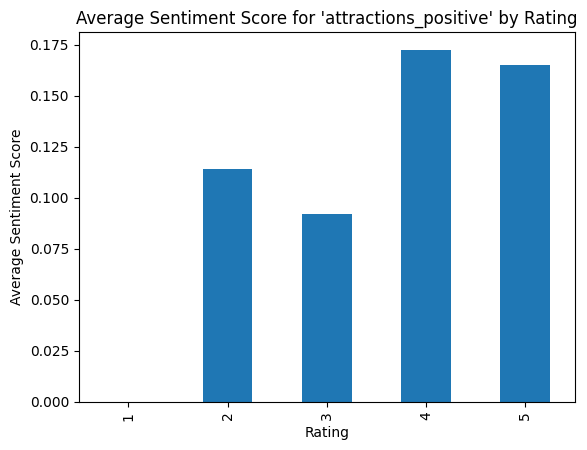

In [61]:
import matplotlib.pyplot as plt

# Example: Bar plot of average sentiment severity for a specific touchpoint-sentiment category
category_to_plot = 'attractions_positive'  # adjust as needed
df_analysis.groupby('Rating')[category_to_plot].mean().plot(kind='bar')
plt.title(f"Average Sentiment Score for '{category_to_plot}' by Rating")
plt.xlabel("Rating")
plt.ylabel("Average Sentiment Score")
plt.show()


In [85]:
merged_df

,Review_ID,touchpoint,sentiment,code,text_excerpt,travel_party,first_visit,visit_timing,Rating,Year_Month,Location,Review_Text,Branch,touchpoint_sentiment,Review_Length
0,531138321,timing,positive,Halloween party first night,this was the first night of the events scheduled,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,timing_positive,86
1,531138321,attractions,negative,long ride lines,really long ride lines,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,attractions_negative,86
2,531138321,entertainment,positive,good main parade,The main parade was good,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,entertainment_positive,86
3,531138321,entertainment,positive,excellent fire works,the fire works excellent,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,entertainment_positive,86
4,531138321,atmosphere,positive,costumes at their best,costumes are at their best,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,atmosphere_positive,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5159,558932183,navigation,positive,effective use of park maps,would suggest to make proper use of maps and t...,family,yes,Sunday,4,2017-07-01,India,Well . visiting Disney Land for the first ti...,Disneyland_HongKong,navigation_positive,358
5160,558932183,food/beverage,negative,limited ethnic food options,being an Indian we would prefer Asian or India...,family,yes,Sunday,4,2017-07-01,India,Well . visiting Disney Land for the first ti...,Disneyland_HongKong,food/beverage_negative,358
5161,558932183,food/beverage,negative,inaccurate restaurant information,"Also, the Indian restaurants that were shown o...",family,yes,Sunday,4,2017-07-01,India,Well . visiting Disney Land for the first ti...,Disneyland_HongKong,food/beverage_negative,358
5162,558932183,entertainment,positive,memorable fireworks show,the very famous Disney Fireworks (09:00 pm) a ...,family,yes,Sunday,4,2017-07-01,India,Well . visiting Disney Land for the first ti...,Disneyland_HongKong,entertainment_positive,358


In [100]:
# Compute the number of words in the full review text
df_sent['review_length'] = df_sent['Review_Text'].apply(lambda x: len(x.split()))


In [101]:
# Aggregate total sentiment per touchpoint per review
df_sentiment_sum = (
    df_sent.groupby(['Review_ID', 'touchpoint_sentiment'])['sentiment_score']
      .sum()
      .unstack(fill_value=0)
      .reset_index()
)

# Also get the count of coded items per review
df_counts = (
    df_sent.groupby('Review_ID')['sentiment_score']
      .count()
      .reset_index()
      .rename(columns={'sentiment_score': 'num_mentions'})
)

# Merge the two dataframes and compute normalized sentiment
df_agg = pd.merge(df_sentiment_sum, df_counts, on='Review_ID')
for col in df_sentiment_sum.columns:
    if col != 'Review_ID':
        df_agg[col + '_normalized'] = df_agg[col] / df_agg['num_mentions']


In [105]:
df_sent

,Review_ID,touchpoint,sentiment,code,text_excerpt,travel_party,first_visit,visit_timing,Rating,Year_Month,Location,Review_Text,Branch,sentiment_score,touchpoint_sentiment,review_length
0,531138321,timing,positive,Halloween party first night,this was the first night of the events scheduled,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,0.0000,timing_positive,86
1,531138321,attractions,negative,long ride lines,really long ride lines,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,0.0000,attractions_negative,86
2,531138321,entertainment,positive,good main parade,The main parade was good,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,0.4404,entertainment_positive,86
3,531138321,entertainment,positive,excellent fire works,the fire works excellent,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,0.3182,entertainment_positive,86
4,531138321,atmosphere,positive,costumes at their best,costumes are at their best,NaN,NaN,Halloween,5,2017-09-01,United Kingdom,We visited for Mickey;s Not So Scary Halloween...,Disneyland_California,0.6369,atmosphere_positive,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5159,558932183,navigation,positive,effective use of park maps,would suggest to make proper use of maps and t...,family,yes,Sunday,4,2017-07-01,India,Well . visiting Disney Land for the first ti...,Disneyland_HongKong,-0.1531,navigation_positive,358
5160,558932183,food/beverage,negative,limited ethnic food options,being an Indian we would prefer Asian or India...,family,yes,Sunday,4,2017-07-01,India,Well . visiting Disney Land for the first ti...,Disneyland_HongKong,0.0000,food/beverage_negative,358
5161,558932183,food/beverage,negative,inaccurate restaurant information,"Also, the Indian restaurants that were shown o...",family,yes,Sunday,4,2017-07-01,India,Well . visiting Disney Land for the first ti...,Disneyland_HongKong,-0.2960,food/beverage_negative,358
5162,558932183,entertainment,positive,memorable fireworks show,the very famous Disney Fireworks (09:00 pm) a ...,family,yes,Sunday,4,2017-07-01,India,Well . visiting Disney Land for the first ti...,Disneyland_HongKong,0.3995,entertainment_positive,358


In [106]:
# Extract unique review IDs and their corresponding Rating from df_sent
review_info = df_sent[['Review_ID', 'Rating']].drop_duplicates(subset='Review_ID')

# Merge the unique review ratings into df_agg based on Review_ID
df_agg = pd.merge(df_agg, review_info, on='Review_ID', how='left')


In [107]:
df_agg

,Review_ID,atmosphere_negative,atmosphere_positive,attractions_negative,attractions_neutral,attractions_none,attractions_positive,characters_negative,characters_positive,cleanliness_negative,...,retail_neutral_normalized,retail_positive_normalized,staff_negative_normalized,staff_positive_normalized,timing_negative_normalized,timing_positive_normalized,value_negative_normalized,value_neutral_normalized,value_positive_normalized,Rating
0,2158032,0.0,0.4404,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.149240,0.000000,0.000000,0.000000,0.0,0.000000,5
1,3312029,0.0,0.0000,-0.7724,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.026154,0.000000,0.0,0.000000,4
2,3460644,0.0,0.0000,0.4215,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,-0.025144,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1
3,5441704,0.0,0.7964,0.0000,0.0,0.0,1.3369,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.042948,0.017474,0.000000,0.000000,0.0,0.000000,5
4,14612611,0.0,0.6369,-0.7965,0.0,0.0,0.0682,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,663906165,0.0,0.8020,0.4875,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,-0.035292,0.000000,0.000000,0.000000,0.052369,0.0,0.000000,3
796,665571020,0.0,0.0000,-0.5859,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.056667,0.000000,0.000000,0.000000,0.0,0.000000,3
797,667509247,0.0,0.0000,0.0000,0.0,0.0,0.5994,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.181725,4
798,668642940,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,5


In [109]:
import statsmodels.api as sm
import numpy as np

# Select all numeric columns from df_agg
numeric_cols = df_agg.select_dtypes(include=[np.number]).columns

# Remove the dependent variable 'Rating' and any identifier columns (e.g., 'Review_ID') from the predictors
predictor_columns = [col for col in numeric_cols if col not in ['Rating', 'Review_ID']]

# Prepare the predictors (X) and dependent variable (y)
X = df_agg[predictor_columns]
X = sm.add_constant(X)  # add an intercept term
y = df_agg['Rating']

# Fit the OLS model and print the summary
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     6.370
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           3.35e-41
Time:                        20:56:04   Log-Likelihood:                -939.93
No. Observations:                 800   AIC:                             2022.
Df Residuals:                     729   BIC:                             2354.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     6.370
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           3.35e-41
Time:                        20:57:38   Log-Likelihood:                -939.93
No. Observations:                 800   AIC:                             2022.
Df Residuals:                     729   BIC:                             2354.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

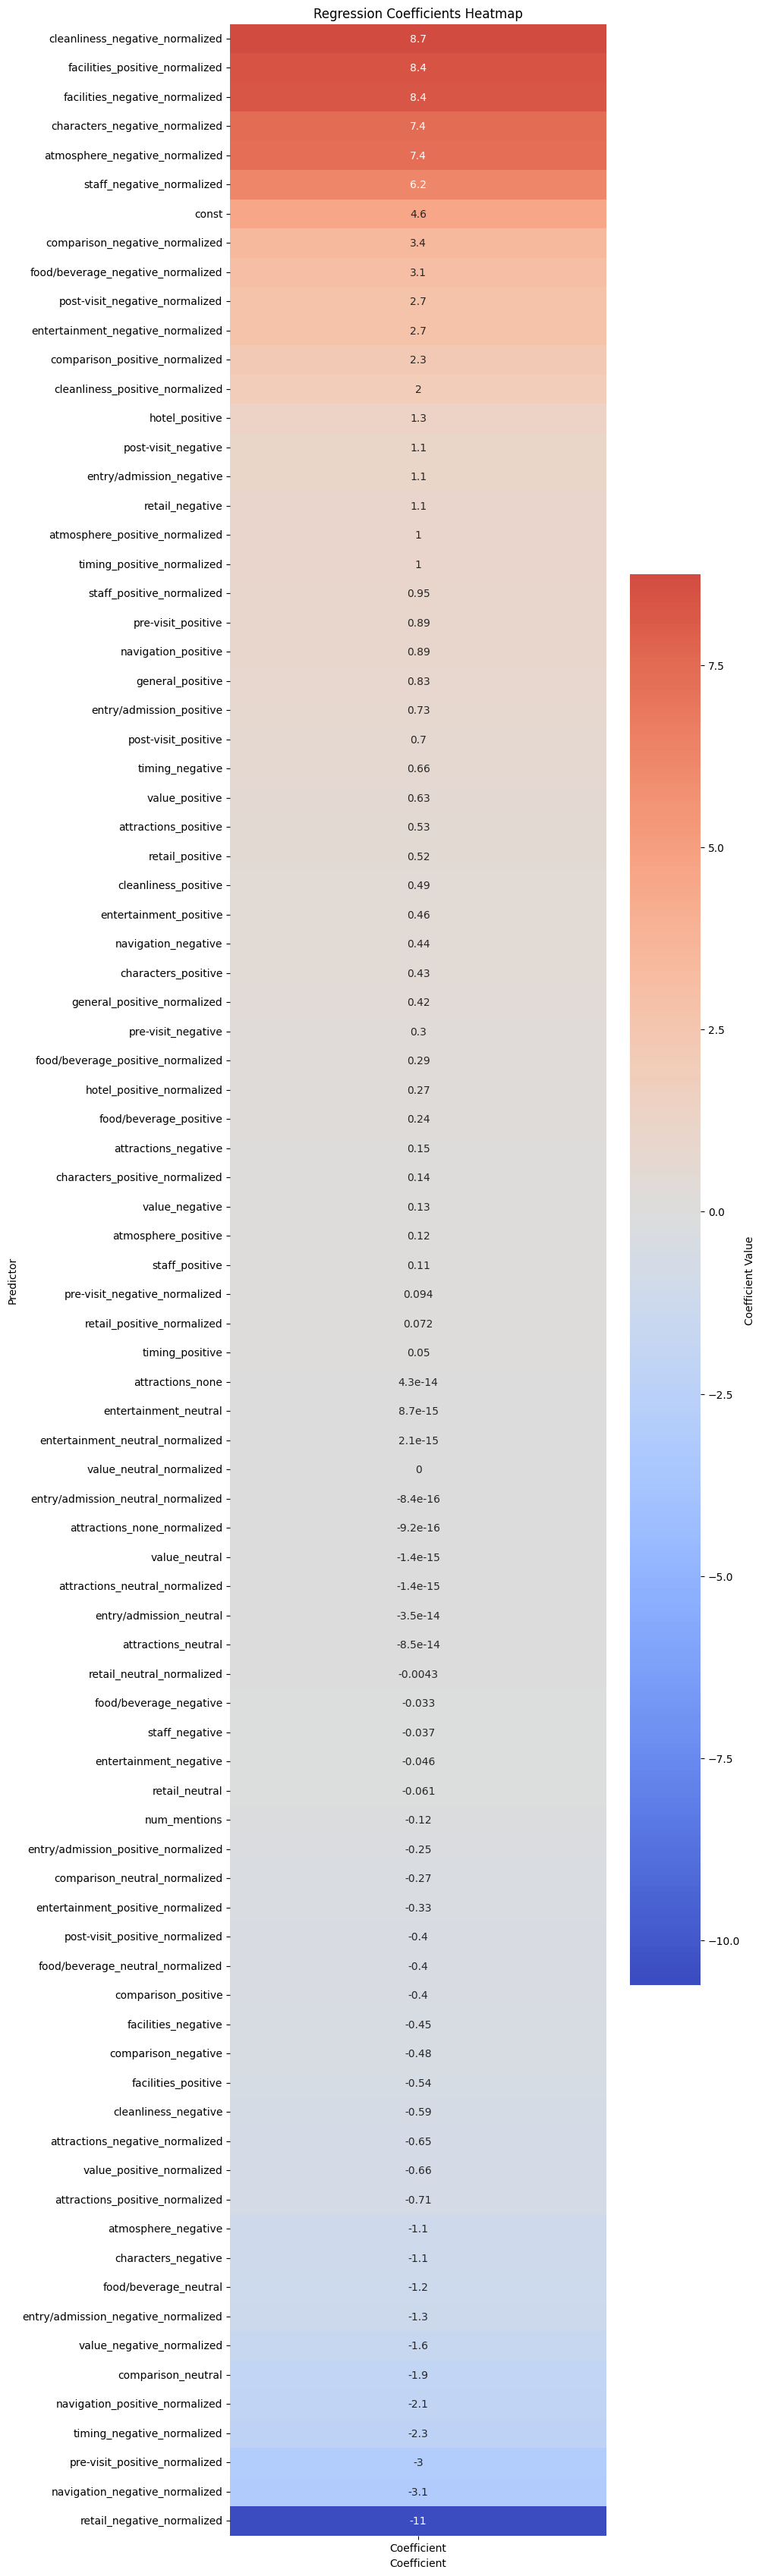

In [110]:

import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Select all numeric predictors except Rating and Review_ID (or any identifier)
numeric_cols = df_agg.select_dtypes(include=[np.number]).columns
predictor_columns = [col for col in numeric_cols if col not in ['Rating', 'Review_ID']]

# Prepare predictors (X) and outcome variable (y)
X = df_agg[predictor_columns]
X = sm.add_constant(X)  # add intercept term
y = df_agg['Rating']

# Fit the OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

# Extract the coefficients and put them in a DataFrame
coef_df = pd.DataFrame(model.params, columns=['Coefficient'])
# Optionally sort by coefficient value for better visualization
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Create a heatmap of the coefficients
plt.figure(figsize=(8, len(coef_df)*0.5))
sns.heatmap(coef_df, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Coefficient Value'})
plt.title('Regression Coefficients Heatmap')
plt.ylabel('Predictor')
plt.xlabel('Coefficient')
plt.show()


In [113]:
df_analysis

,Review_ID,atmosphere_negative,atmosphere_positive,attractions_negative,attractions_neutral,attractions_none,attractions_positive,characters_negative,characters_positive,cleanliness_negative,...,retail_positive,staff_negative,staff_positive,timing_negative,timing_positive,value_negative,value_neutral,value_positive,Rating,Branch
0,2158032,0.0,0.4404,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0000,0.7462,0.0000,0.00,0.0000,0.0,0.0000,5,Disneyland_California
1,3312029,0.0,0.0000,-0.3862,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0000,0.0000,0.0000,0.34,0.0000,0.0,0.0000,4,Disneyland_Paris
2,3460644,0.0,0.0000,0.1405,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,-0.2263,0.0000,0.0000,0.00,0.0000,0.0,0.0000,1,Disneyland_Paris
3,5441704,0.0,0.3982,0.0000,0.0,0.0,0.334225,0.0,0.0,0.0,...,0.0,0.0000,0.4939,0.4019,0.00,0.0000,0.0,0.0000,5,Disneyland_Paris
4,14612611,0.0,0.2123,-0.7965,0.0,0.0,0.034100,0.0,0.0,0.0,...,0.0,0.0000,0.0000,0.0000,0.00,0.0000,0.0,0.0000,5,Disneyland_California
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,663906165,0.0,0.8020,0.1625,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,-0.4588,0.0000,0.0000,0.00,0.3404,0.0,0.0000,3,Disneyland_Paris
796,665571020,0.0,0.0000,-0.1953,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0000,0.3400,0.0000,0.00,0.0000,0.0,0.0000,3,Disneyland_Paris
797,667509247,0.0,0.0000,0.0000,0.0,0.0,0.599400,0.0,0.0,0.0,...,0.0,0.0000,0.0000,0.0000,0.00,0.0000,0.0,0.7269,4,Disneyland_HongKong
798,668642940,0.0,0.0000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0000,0.0000,0.0000,0.00,0.0000,0.0,0.0000,5,Disneyland_California


Chosen alpha: 0.002320746864796371
Coefficients (sorted):
post-visit_negative                1.715036
cleanliness_positive               0.749190
entry/admission_negative           0.724857
entry/admission_positive           0.633123
post-visit_positive                0.572661
                                     ...   
cleanliness_positive_normalized    0.000000
comparison_negative_normalized     0.000000
attractions_negative              -0.015951
num_mentions                      -0.101949
retail_negative                   -0.107144
Length: 85, dtype: float64
Test MSE: 0.7450389012462508
Test R^2: 0.2175181180757324
Chosen alpha: 0.002320746864796371
Coefficients (sorted):
post-visit_negative                1.715036
cleanliness_positive               0.749190
entry/admission_negative           0.724857
entry/admission_positive           0.633123
post-visit_positive                0.572661
                                     ...   
cleanliness_positive_normalized    0.000000
compari

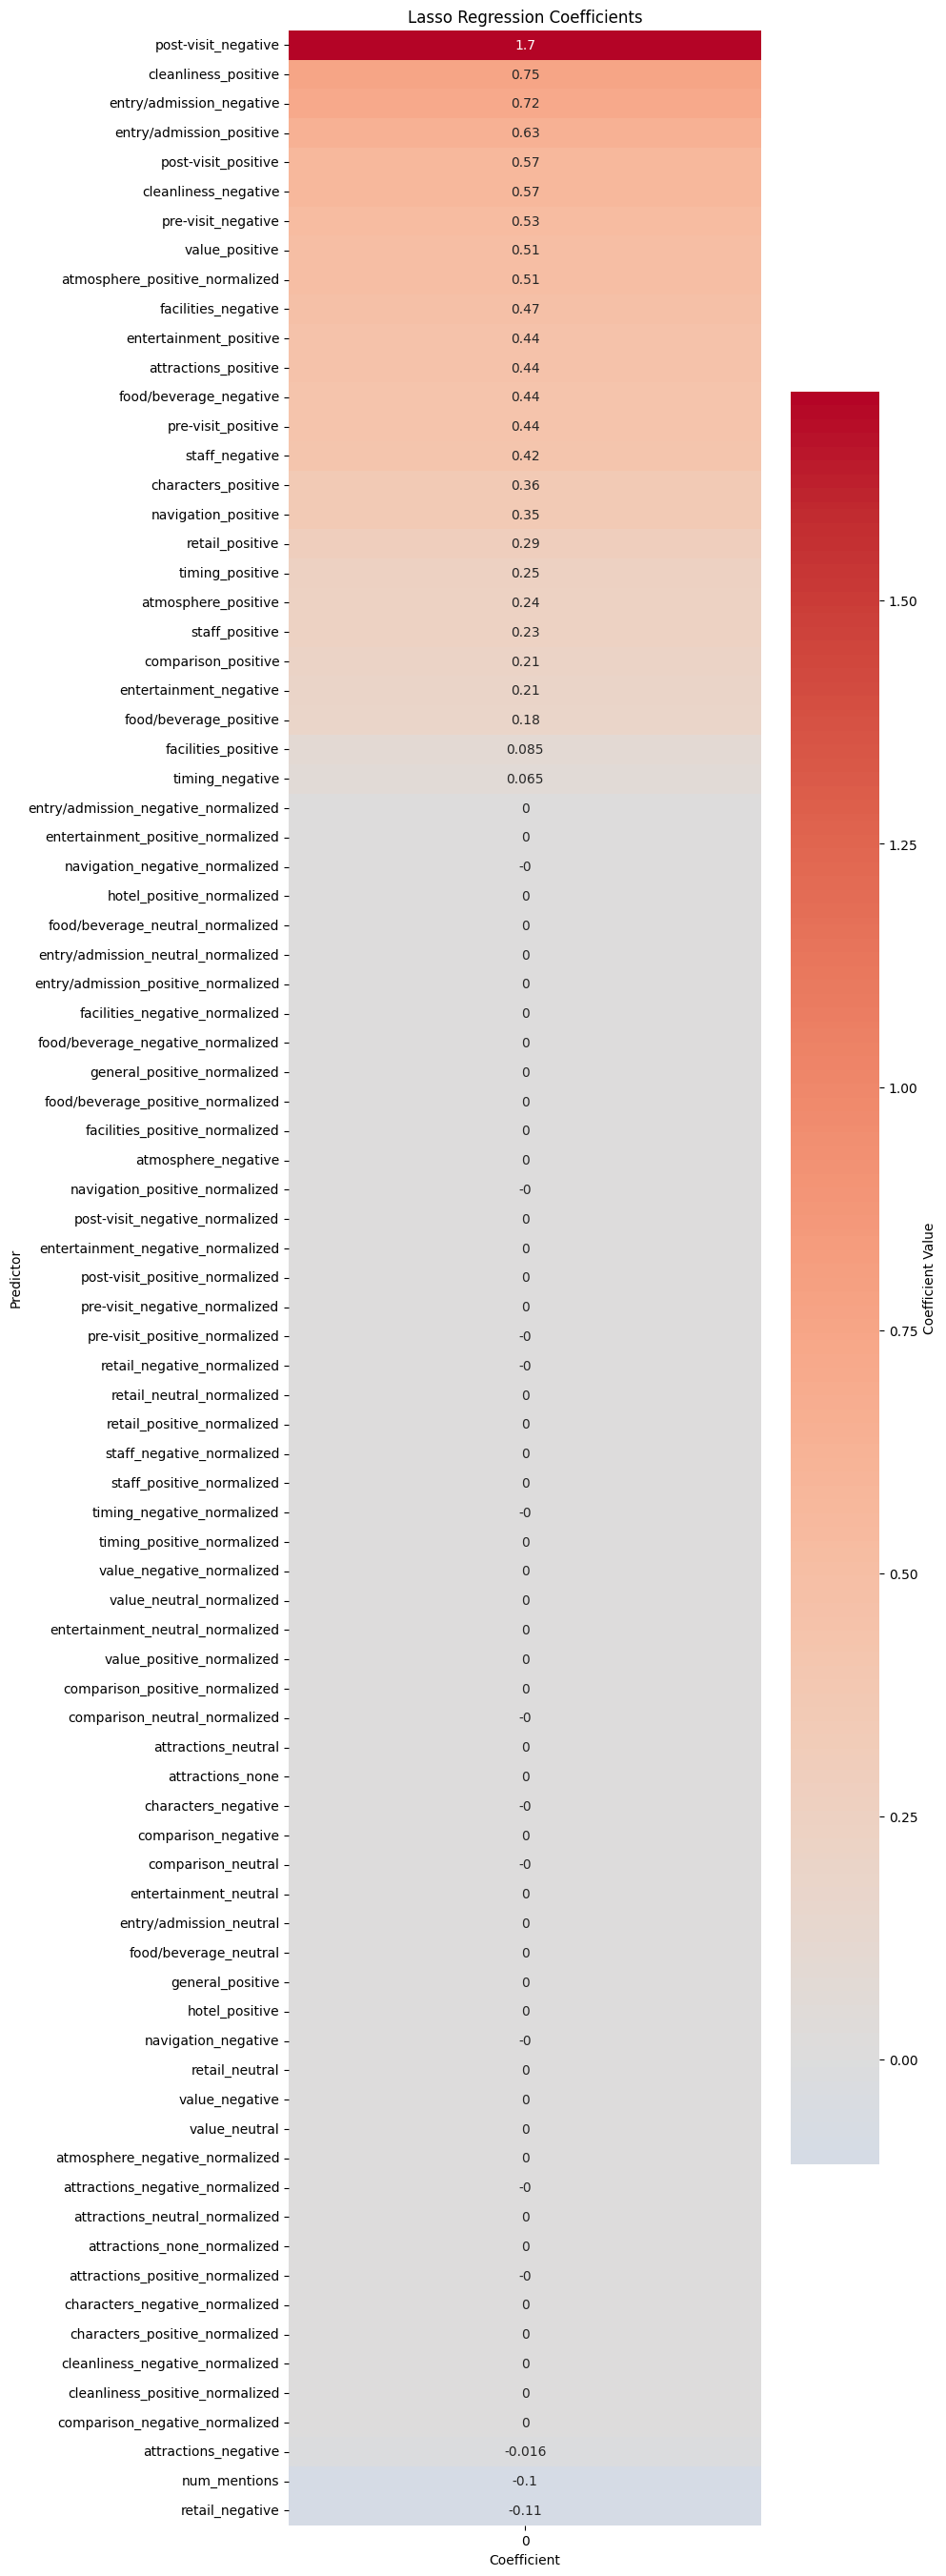

0.0017717133818958475
[-0.          0.22161155  0.          0.          0.          0.41318538
 -0.          0.44765016  0.5551481   0.69406738  0.01689183 -0.
  0.          0.05111951  0.          0.40282779  0.7830339   0.
  0.61263058  0.68951018  0.15766172  0.25357215 -0.          0.25253444
  0.          0.         -0.          0.43368965  1.49112836  0.61046307
  0.0622151   0.43874925 -0.          0.          0.37429229  0.49830079
  0.26135426  0.00586656  0.20695323 -0.          0.          0.40715086
 -0.10563021  0.          0.65433514 -0.          0.          0.
 -0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
  0.          0.          0.         -0.          0.          0.
 -0.          0.         -0.         -0.          0.          0.
  0.36369622  0.          0.          0.          0.          0.
  0.        ]


In [115]:
from sklearn.linear_model import LassoCV
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1. Identify the numeric columns and exclude 'Rating' and 'Review_ID'
numeric_cols = df_agg.select_dtypes(include=[np.number]).columns
predictors = [col for col in numeric_cols if col not in ['Rating', 'Review_ID']]

# 2. Define X and y
X = df_agg[predictors]
y = df_agg['Rating']

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

# 4. Fit LassoCV
lasso_model = LassoCV(cv=5, random_state=42)
lasso_model.fit(X_train, y_train)

# 5. Inspect results
print("Chosen alpha:", lasso_model.alpha_)
coefficients = pd.Series(lasso_model.coef_, index=predictors).sort_values(ascending=False)
print("Coefficients (sorted):")
print(coefficients)

# 6. Evaluate on the test set
y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test R^2:", r2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1. Prepare your data
#    Assume df_agg is your DataFrame with numeric predictors and 'Rating' as the outcome.
#    We’ll select columns for X, excluding 'Rating' and 'Review_ID' (or other IDs).
numeric_cols = df_agg.select_dtypes(include=[np.number]).columns
predictor_columns = [col for col in numeric_cols if col not in ['Rating', 'Review_ID']]

X = df_agg[predictor_columns]
y = df_agg['Rating']

# 2. Split the data into training and testing sets (80/20 split, for example)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42  # for reproducibility
)

# 3. Initialize and fit the LassoCV model
#    - cv=5 uses 5-fold cross-validation
#    - You can adjust other hyperparameters (e.g., max_iter, etc.) if needed.
lasso_model = LassoCV(cv=5, random_state=42)
lasso_model.fit(X_train, y_train)

# 4. Check which alpha was chosen
print("Chosen alpha:", lasso_model.alpha_)

# 5. Examine the coefficients
coefficients = pd.Series(lasso_model.coef_, index=predictor_columns)
coefficients = coefficients.sort_values(ascending=False)
print("Coefficients (sorted):")
print(coefficients)

# 6. Evaluate on the test set
y_pred = lasso_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test R^2:", r2)

# 7. Optional: visualize the coefficients
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, len(coefficients)*0.4))
sns.heatmap(coefficients.to_frame(), annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Coefficient Value'})
plt.title('Lasso Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Predictor')
plt.show()

model_lasso = LassoCV(cv=5).fit(X, y)
print(model_lasso.alpha_)
print(model_lasso.coef_)


In [116]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, ElasticNetCV

# Assume df_agg is your DataFrame with 'Rating' as the target and 'Review_ID' as an identifier.
# First, select all numeric columns, then exclude 'Rating' and 'Review_ID' from predictors.
numeric_cols = df_agg.select_dtypes(include=[np.number]).columns
predictors = [col for col in numeric_cols if col not in ['Rating', 'Review_ID']]

# Define predictors (X) and outcome variable (y)
X = df_agg[predictors]
y = df_agg['Rating']

# --- 1. Check for Multi-Collinearity: Compute VIF for each predictor ---
# Add a constant to the predictors for VIF computation.
X_with_const = sm.add_constant(X)
vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X_with_const.values, i+1)  # i+1 because the constant is column 0
            for i in range(len(X.columns))]
})
print("Variance Inflation Factor (VIF) for each predictor:")
print(vif_data)

# --- 2. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Implement Ridge Regression with Cross-Validation ---
# Define a range of alpha values for Ridge.
ridge_alphas = np.logspace(-4, 4, 50)
ridge_model = RidgeCV(alphas=ridge_alphas, cv=5)
ridge_model.fit(X_train, y_train)

# Create a Series for easy viewing of coefficients
ridge_coef = pd.Series(ridge_model.coef_, index=predictors).sort_values(ascending=False)

print("\nRidgeCV Results:")
print("Chosen alpha:", ridge_model.alpha_)
print("Ridge Coefficients:")
print(ridge_coef)

# Evaluate Ridge on the test set
y_pred_ridge = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)
print("Ridge Test MSE:", ridge_mse)
print("Ridge Test R^2:", ridge_r2)

# --- 4. Implement ElasticNet with Cross-Validation ---
elastic_net_model = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9, 1.0], cv=5, random_state=42)
elastic_net_model.fit(X_train, y_train)

elastic_coef = pd.Series(elastic_net_model.coef_, index=predictors).sort_values(ascending=False)

print("\nElasticNetCV Results:")
print("Chosen alpha:", elastic_net_model.alpha_)
print("Chosen l1_ratio:", elastic_net_model.l1_ratio_)
print("ElasticNet Coefficients:")
print(elastic_coef)

# Evaluate ElasticNet on the test set
y_pred_enet = elastic_net_model.predict(X_test)
enet_mse = mean_squared_error(y_test, y_pred_enet)
enet_r2 = r2_score(y_test, y_pred_enet)
print("ElasticNet Test MSE:", enet_mse)
print("ElasticNet Test R^2:", enet_r2)


/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factor (VIF) for each predictor:
                       feature       VIF
0          atmosphere_negative  5.921744
1          atmosphere_positive  3.085551
2         attractions_negative  2.895037
3          attractions_neutral       NaN
4             attractions_none       NaN
..                         ...       ...
80  timing_negative_normalized  3.024651
81  timing_positive_normalized  4.500773
82   value_negative_normalized  5.310149
83    value_neutral_normalized       NaN
84   value_positive_normalized  3.290637

[85 rows x 2 columns]

RidgeCV Results:
Chosen alpha: 5.428675439323859
Ridge Coefficients:
post-visit_negative                1.104993
cleanliness_positive               0.595856
post-visit_positive                0.544857
entry/admission_negative           0.519496
entry/admission_positive           0.502825
                                     ...   
comparison_neutral                -0.076880
retail_negative_normalized        -0.084934
num_mention

In [118]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assume df_agg is your DataFrame.
# Select numeric predictors excluding 'Rating' and 'Review_ID'
numeric_cols = df_agg.select_dtypes(include=[np.number]).columns
predictors = [col for col in numeric_cols if col not in ['Rating', 'Review_ID']]

# Define predictors (X) and outcome variable (y)
X = df_agg[predictors]
y = df_agg['Rating']

# Optionally check distribution of ratings
print("Rating distribution:")
print(y.value_counts())

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# IMPORTANT: Do NOT add a constant when using OrderedModel
model = OrderedModel(y_train, X_train, distr='logit')

# Fit the ordinal logistic regression model; adjust method/iterations as needed.
res = model.fit(method='bfgs', disp=False)
print(res.summary())

# --- Optionally, evaluate on the test set ---
# Predict probabilities for each category on the test set
predicted_probs = res.predict(X_test)

# Get the most likely category (highest probability) for each observation
y_pred = predicted_probs.idxmax(axis=1)

# Evaluate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest set accuracy (most likely category): {accuracy:.2%}")


Rating distribution:
Rating
5    445
4    214
3     89
2     29
1     23
Name: count, dtype: int64


/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/homebrew/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             OrderedModel Results                             
Dep. Variable:                 Rating   Log-Likelihood:                -588.22
Model:                   OrderedModel   AIC:                             1354.
Method:            Maximum Likelihood   BIC:                             1752.
Date:                Sun, 23 Mar 2025                                         
Time:                        21:15:33                                         
No. Observations:                 640                                         
Df Residuals:                     551                                         
Df Model:                          85                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
atmosphere_negative                    -1.8670        nan        nan        nan  

In [119]:
# Suppose you've identified a subset of predictors:
key_predictors = ['post-visit_negative', 'post-visit_positive', 
                  'entry/admission_negative', 'entry/admission_positive', 
                  'cleanliness_positive', 'cleanliness_negative']

X_reduced = df_agg[key_predictors]
y = df_agg['Rating']

from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.model_selection import train_test_split

# Split data
X_train_red, X_test_red, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Fit the ordinal model without adding a constant
model_reduced = OrderedModel(y_train, X_train_red, distr='logit')
res_reduced = model_reduced.fit(method='bfgs', disp=False)
print(res_reduced.summary())


                             OrderedModel Results                             
Dep. Variable:                 Rating   Log-Likelihood:                -694.93
Model:                   OrderedModel   AIC:                             1410.
Method:            Maximum Likelihood   BIC:                             1454.
Date:                Sun, 23 Mar 2025                                         
Time:                        21:18:15                                         
No. Observations:                 640                                         
Df Residuals:                     630                                         
Df Model:                           6                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
post-visit_negative          3.5501      0.735      4.833      0.000       2.111       4.990
post-visit

In [ ]:
import pandas as pd

df = pd.read_csv("../../data/A1/DisneylandReviews_Coded.csv")


def create_rich_embedding_text(row):
    return f"{row['code']}"

print("Creating rich text for embeddings...")
df['embedding_text'] = df.apply(create_rich_embedding_text, axis=1)
print(df['embedding_text'].head())


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/alan_a/Desktop/DSA3101GIT/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3549, in run_code
  File "/var/folders/4k/8zjs5w191wn6mjqcxkws37dw0000gn/T/ipykernel_54483/3108257279.py", line 1, in <module>
    import pandas as pd
ModuleNotFoundError: No module named 'pandas'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/alan_a/Desktop/DSA3101GIT/.venv/lib/python3.13/site-packages/pygments/styles/__init__.py", line 45, in get_style_by_name
ModuleNotFoundError: No module named 'pygments.styles.default'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/alan_a/Desktop/DSA3101GIT/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 2173, in showtraceback
  File "/Users/alan_a/Desktop/DSA3101GIT/.venv/lib/python3.13/site-packages/IPython/core/ultratb.py", li

In [ ]:

client = genai.Client(api_key=c.GEMINI)
# Batch processing function
def process_in_batches(dataframe, batch_size=50):
    all_embeddings = []
    for i in tqdm(range(0, len(dataframe), batch_size), desc="Processing batches"):
        end_idx = min(i + batch_size, len(dataframe))
        batch = dataframe['embedding_text'].iloc[i:end_idx].tolist()
        try:
            result = client.models.embed_content(
                model="gemini-embedding-exp-03-07",
                contents=batch,
                config=types.EmbedContentConfig(task_type="CLUSTERING")
            )
            # Extract embeddings from response
            batch_embeddings = [emb.embedding for emb in result["embedding"]]
            print(result.embeddings)
            all_embeddings.extend(batch_embeddings)
        except Exception as e:
            print(f"Error in batch {i}-{end_idx}: {e}")
            # Fill failed batch with None values
            all_embeddings.extend([None] * len(batch))
            
    return all_embeddings

# Start batch embedding process
print("Starting batch embedding process...")
df["embedding"] = process_in_batches(df, batch_size=1)


output_path = "../../data/A1/DisneylandReviews_Embedded.csv"
print(f"Saving embeddings to {output_path}")
df.to_csv(output_path, index=False)

print(f"Total rows: {len(df)}")
print(f"Successful embeddings: {df['embedding'].notna().sum()}")
print(f"Failed embeddings: {df['embedding'].isna().sum()}")